In [26]:
# Load the data
import csv
import numpy as np
from pprint import pprint
import os

path = os.listdir("./raw_data")[0]
with open(f"./raw_data/{path}") as fin:
    reader = csv.reader(fin, delimiter=",")
    raw_data = list(reader)

    def convert(raw_data):
        return -1 if raw_data == "" else int(raw_data)

    data = []
    for row in raw_data[1:]:
        data.append([])
        for col in range(3, len(raw_data[0]) - 2):
            data[-1].append(convert(row[col]))
    
    mat = np.array(data).T

print(mat, mat.shape)
print(np.sum(mat == -1))

[[-1  7  5  7  1  4  3  3 -1  7  7  4  2  3  5  5 -1  7  3  5  3  1  6  6
   7  5  5  3  6  6  4  5  5  6  1  7  3  1  5 -1 -1  5  3  5  5  6 -1  7
   1  3  4  2  1  6  4  5  6  6  4  4  5  3  4  2  3]
 [-1  5  2 -1  4  4  5  7  2 -1  7  1  1 -1  1  2 -1  4  3  2  4  5  4  2
   4  1  2  2  2  5  1  6  3 -1  1  5 -1  4  5 -1  4  3  4  1  6  7 -1  5
   1  4  5  1  5  2  1  4  1  5  6  2  5  1  1  2  6]
 [-1 -1 -1 -1 -1 -1  1  7  3 -1 -1  1  1 -1 -1  6 -1  4 -1  1 -1 -1 -1 -1
  -1 -1  1  2  5 -1  4 -1 -1 -1  1 -1  1  1 -1 -1 -1  4  1  4  4  5 -1 -1
   1  1  4 -1  5 -1  3  6 -1 -1  5 -1 -1  1  1 -1 -1]
 [ 6  2  7  7  7  6  7  3  6  7  7  7  5  7  6  6  7  5  6  7  6  6  3  6
   7  6  7  6  6  7  7  6  6  7  6  7  6  6  6  5  5  6  4  7  6  7  7  6
   5  5  7  7  7  5  4  7  2  6  6  5  7  6  6  6  6]
 [ 5  1  7  4  7  3  3  3  4  6  6  7  7  4  6  7  3  6  5  5  5  5  4  5
   6  7  7  5  7  7  7  3  2  7  3  4  4  1  6  7  5  5  4  6  7  7  7  4
   3  6  5  6  3  4  4  5  5  4  7  6  5  7 

In [27]:
# Get food labels
import re

pattern = r".*?\[(.*)].*"
food_labels = [re.findall(pattern, header)[0] for header in raw_data[0][3:-2]]

In [28]:
import numpy as np
def test():
    M = [[3, 10, 2, 9, 3, -1, -1, 4],
         [3, -1, -1, 4, 9, 2, 3, 1],
         [4, -1, 2, 4, 3, 5, 1, -1],
         [-1, -1, -1, 8, 0, 2, -1, 1],
         [1, 1, -1, 1, 2, 2, -1, -1],
         [4, 4, 4, -1, -1, 10, 10, 10]]
    M = np.array(M, dtype="float")
    return matrixComplete(M, -1, 100000)
    
def matrixComplete(M, missingLabel, steps=1000):
    missing = (M == missingLabel)
    predictions = np.where(missing, np.random.random(size=M.shape), 0)
    rate = 0.01 # totally unused but good for experiments I think
    i = 0
    while True:
        i += 1
        predictedMatrix = np.where(missing, predictions, M)
        if i == steps: return predictedMatrix
        u,s,vT = np.linalg.svd(predictedMatrix)
        if i%(steps//20)==0: print(np.sum(np.abs(s)), rate)
        diag = np.zeros((u.shape[0], vT.shape[0]))
        for j in range(min(diag.shape)): diag[j,j] = 1.0
        derivative = np.where(missing, u @ diag @ vT, 0)
        predictions -= 0.1*derivative
        
        while NuclearNorm(predictedMatrix - rate*derivative) >\
           NuclearNorm(predictedMatrix):
            rate /= 1.1
        else:
            rate *= 1.05

def NuclearNorm(M):
    u,s,v = np.linalg.svd(M)
    return np.sum(np.abs(s))

In [29]:
# Clean up the data a little
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

mean = np.nanmean(mat)
n_foods, n_people = mat.shape

print(f"Mean of nonzero entries: {mean}")
print(f"Count of nonzero entries: {np.count_nonzero(~np.isnan(data))}")

print("Number of entries to fill", np.sum(mat == -1))
mat = matrixComplete(mat, -1, 1000)

# Normalize
# Standardize features?
def fit_rows(mat):
    return StandardScaler().fit_transform(mat)

def fit_cols(mat):
    return StandardScaler().fit_transform(mat.T).T

for i in range(10):
    mat = fit_rows(mat)
    mat = fit_cols(mat)

np.set_printoptions(threshold=np.inf)

# print(mat)

# print("BREAK")

rows, columns = mat.shape
sum = [0] * rows
index = 0
with open("pca_models/mean_foods", "w") as f:
    
    for row in mat:
        print(row)
        for i in row:
            sum[index] += i
        sum[index] /= columns
        f.write(str(sum[index]) + "\n")
        index += 1
    f.close()


# for row in mat.T[:10]:
#     print(np.mean(row), np.var(row))

Mean of nonzero entries: 3.9033846153846152
Count of nonzero entries: 3250
Number of entries to fill 325
781.2094610372975 0.10921333129289235
760.6933106202794 1.2523929318695617
747.6011916113455 14.361690438600458
739.295969650632 32.58328500765888
733.9586245901445 34.4859895107709
730.4799645653429 33.18163877464534
728.1994479562211 35.11928421163286
726.7025571149298 37.17007866651479
725.7176345558593 39.340629488606005
725.0658493098499 41.63792986410945
724.6309702221604 44.069381347103935
724.3381835307239 46.642817706230566
724.139346750347 44.87866378537267
724.0032571683555 47.49935828127776
723.9094764911242 50.27308851981796
723.8444676456189 48.371628218159856
723.7991711095287 51.19629475537115
723.7674893686569 1.1972337442299985
723.7456100286373 0.12864778992418655
[[ 5.66790858e-01  9.14068271e-01  3.82299110e-02  1.32557314e+00
  -1.51077333e+00 -3.44769831e-01 -8.83778257e-01 -8.41183922e-01
   1.11903885e-02  1.06059765e+00  1.40350181e+00  3.68350814e-01
  -1.

In [21]:
mat = np.array([[1, 2, 3, 4], [1, 2, 7, 5]])

mat = np.transpose(mat)
rows, columns = mat.shape
sum = [0] * rows
index = 0
with open("pca_models/mean_foods", "w") as f:
    
    for row in mat:
        print(row)
        for i in row:
            sum[index] += i
        sum[index] /= columns
        f.write(str(sum[index]) + "\n")
        index += 1
    f.close()

mat = np.transpose(mat)

print(sum)


[1 1]
[2 2]
[3 7]
[4 5]
[1.0, 2.0, 5.0, 4.5]


In [8]:
# Let's do some PCA!
from sklearn.decomposition import PCA
import json

pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

pc_2 = pca_2d.fit_transform(mat)
pc_3 = pca_3d.fit_transform(mat)

with open("../visualization/data/food_3d_points.json", "w") as fout:
    json.dump({
        "points": pc_3.tolist(),
        "labels": food_labels
    }, fout)

8

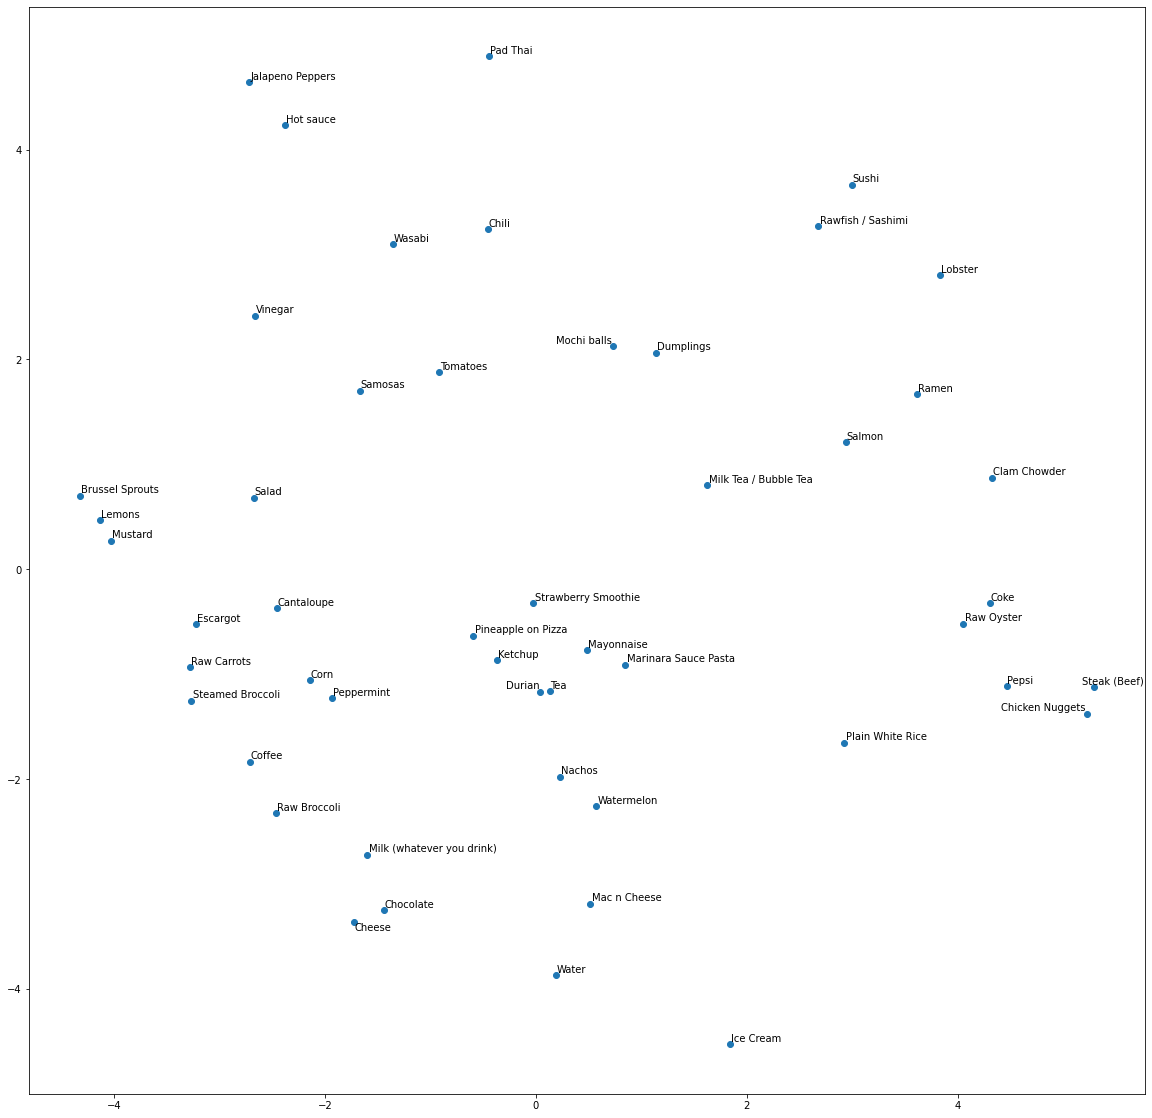

In [11]:
from matplotlib import pyplot as plt
from adjustText import adjust_text

fig = plt.figure(figsize=(20, 20))

#plot_3d = fig.add_subplot(2, 2, 1, projection="3d")
#plot_3d.scatter(*pc_3.T)

plot_2d = fig.add_subplot()
plot_2d.scatter(*pc_2.T)

labels = []
for food, coords in zip(food_labels, pc_2):
    labels.append(plt.text(coords[0], coords[1], food, ha="left", va="top"))

adjust_text(labels)